In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

import sys, os
sys.path.insert(0, '../')
from dfHelper import*

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

!pip install skforecast

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

  Using cached skforecast-0.4.3-py2.py3-none-any.whl (87 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 357.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 348.7 kB/s eta 0:00:0000:0100:01
  Using cached tqdm-4.62.0-py2.py3-none-any.whl (76 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 199.1 kB/s eta 0:00:0000:0100:03
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
  Attempting uninstall: joblib
    Found existing installation: joblib 0.17.0
    Uninstalling joblib-0.17.0:
      Successfully uninstalled joblib-0.17.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstall

In [43]:
import numpy as np
import pandas as pd

def load_data_adl(user, run, path):
    """
    Loads the data for a given user and run.
    """

    from string import digits
    # get names for all the columns
    header = np.loadtxt(path+'/dataset/column_names.txt', delimiter='\n', dtype=str, skiprows=1)
    header = header.tolist()
    header.remove('Label columns: ')
    remove_digits = str.maketrans('', '', digits)

    header = list(map (lambda x: x.replace('Column: ', '').split(";", 1)[0].translate(remove_digits).lstrip(), header))

    data = pd.read_csv(path+f'/dataset/S{user}-ADL{run}.dat', sep=' ', header=None)
    data.columns = header

    #save a file with columns names
    import os
    if not os.path.isdir('data_cleaned'): os.mkdir('data_cleaned')
    columns = np.array(data.columns)
    np.savetxt('data_cleaned/columns_opportunity.txt', columns, fmt='%s')
    
    return data

def get_HL_activity(data, highlevel_label):
    """
    parameters:
    data: pandas dataframe
    highlevel_label: number corresponding to the highlevel activity
    """
    if not highlevel_label in {101, 102, 103, 104, 105}:
         raise ValueError('highlevel_label must be one of the following: 101, 102, 103, 104, 105')
    return data[data['HL_Activity'] == highlevel_label]

def get_HL_activity_data(data, highlevel_labels = [101, 102, 103, 104, 105]):
    """
    returns data for a given highlevel activity

    parameters:
    data: pandas dataframe
    highlevel_labels: list of numbers corresponding to the highlevel activities

    101   -   HL_Activity   -   Relaxing
    102   -   HL_Activity   -   Coffee time
    103   -   HL_Activity   -   Early morning
    104   -   HL_Activity   -   Cleanup
    105   -   HL_Activity   -   Sandwich time

    """
    if not set(highlevel_labels).issubset({101, 102, 103, 104, 105}) != len(highlevel_labels): 
        raise ValueError('highlevel_label must be one of the following: 101, 102, 103, 104, 105')

    df = data[data['HL_Activity']==highlevel_labels[0]]
    for i in range(1, len(highlevel_labels)):
        df = df.append(get_HL_activity(data, highlevel_labels[i]))
    df.reset_index(drop=True, inplace=True)

    return df
    
def get_locomotion(data, loc):
    """
    parameters:
    data: pandas dataframe
    highlevel_label: number corresponding to the highlevel activity
    """
    if not loc in {1, 2, 3, 4, 5 }: raise ValueError('loc must be one of the following: 1, 2, 3, 4, 5')
    return data[data['Locomotion'] == loc]

def get_locomotion_data(data, locs = [1, 2, 4, 5]):
    """
    returns data for a given locomotion activity
    parameters:
    data: pandas dataframe
    loc: list of numbers corresponding to the locomotion activities

    1   -   Locomotion   -   Stand
    2   -   Locomotion   -   Walk
    4   -   Locomotion   -   Sit
    5   -   Locomotion   -   Lie

    """

    if not set(locs).issubset({1, 2, 4, 5}): 
        raise ValueError('loc must be one of the following: 1, 2, 4, 5')

    df = data[data['Locomotion']==locs[0]]
    for i in range(1, len(locs)):
        df = df.append(get_locomotion(data, locs[i]))
    df.reset_index(drop=True, inplace=True)
    return df

def get_signals (data, signals):
    """
    parameters:
    data: pandas dataframe
    signals: list of columns labels (strings) for the signals
    """
    if not set(signals).issubset(set(data.columns)): 
        raise ValueError('signals must be a subset of the columns in data')
    columns_keep = [data.columns[0], *signals, *data.columns[243:]]
    return data[columns_keep]

def get_sensor_data(data, sensor_type):
    """
    Following Hanzika thesis we only study gyroscope, accelerometer and magnetometer, 
    x, y and z coordinates are combined into a single single dimension by taking the module

    parameters:
    data: pandas dataframe
    sensor_type: label of the sensors, can be "triaxial_acc", "IMU_acc", "IMU_gyro", "IMU_mag" or "all"
                 see figure at
    """

    if not sensor_type in {'triaxial_acc', 'IMU_acc', 'IMU_gyro', 'IMU_mag', 'all'}:
        raise ValueError('sensor_type must be one of the following: "triaxial_acc", "IMU_acc", "IMU_gyro", "IMU_mag", "all"')
        
    columns = np.loadtxt('data_cleaned/columns_opportunity.txt', delimiter='\n', dtype=str)

    # get the signals for the accelerometer and compute the modulus of the signals on x, y and z
    # accelerometer signals are in 1-37 columns
    if sensor_type == 'triaxial_acc' or sensor_type == 'all':
        acc_columns = columns[1:37]
        acc_data = data[acc_columns]
        for i in range(0, len(acc_data.columns)-3, 3):
            colx, coly, colz =  acc_data.columns[i], acc_data.columns[i+1], acc_data.columns[i+2]
            x, y, z = acc_data[colx], acc_data[coly], acc_data[colz]

            newheader = acc_data.columns[i][:-1]+'_mod'
            acc_data[newheader] = np.sqrt(x**2 + y**2 + z**2)
        acc_data.drop(acc_columns, axis=1, inplace=True)

    # imu signals are in 38-134 columns organized as follows:
    # (acc x, acc y, acc z, gyro y, gyro z, mag x, mag y, mag z, quaternion 1, quaternion 2, quaternion 3, quaternion 4)
    # up to 102
    if sensor_type == 'IMU_acc' or sensor_type == 'all' or sensor_type == 'IMU_gyro' or sensor_type == 'IMU_mag':
        imu_columns = columns[37:102]
        imu_data = data[imu_columns]
        for i in range(0, len(imu_columns), 13):
            #columns 
            if sensor_type == 'IMU_acc' or sensor_type == 'all':
                acccols = imu_columns[i:i+3]
                accx, accy, accz = np.array(imu_data[acccols[0]]), np.array(imu_data[acccols[1]]), np.array(imu_data[acccols[2]])
                accheader = imu_columns[i][:-1]+'_mod'
                imu_data[accheader] = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))
            elif sensor_type == 'IMU_gyro' or sensor_type == 'all':
                gyrocols = imu_columns[i+3:i+6]
                gyrox, gyroy, gyroz = np.array(imu_data[gyrocols[0]]), np.array(imu_data[gyrocols[1]]), np.array(imu_data[gyrocols[2]])
                gyroheader = imu_columns[i+3][:-1]+'_mod'
                imu_data[gyroheader] = np.sqrt(np.square(gyrox) + np.square(gyroy) + np.square(gyroz))
            elif sensor_type == 'IMU_mag' or sensor_type == 'all':
                magcols = imu_columns[i+6:i+9]
                magx, magy, magz = np.array(imu_data[magcols[0]]), np.array(imu_data[magcols[1]]), np.array(imu_data[magcols[2]])
                magheader = imu_columns[i+5][:-1]+'_mod'
                imu_data[magheader] = np.sqrt(np.square(magx) + np.square(magy) + np.square(magz))

        imu_data.drop(imu_columns, axis=1, inplace=True)

    time = data['MILLISEC']
    activity_labels = data[data.columns[-7:]]
    
    if sensor_type == 'all':
        df = acc_data
        df = df.join(time)
        df = df.join(imu_data)
        df = df.join(activity_labels)
    elif sensor_type == 'triaxial_acc':
        df = acc_data
        df = df.join(time)
        df = df.join(activity_labels)
    else:
        df = imu_data
        df = df.join(time)
        df = df.join(activity_labels)
    return df

In [170]:
subject, run = 1, 1
sensor = 'all'

d = load_data_adl(subject, run, '../OpportunityUCIDataset')
stand, walk, sit, lie = get_locomotion_data(d, [1]), get_locomotion_data(d, [2]), get_locomotion_data(d, [4]), get_locomotion_data(d, [5])
stand, walk, sit, lie = get_sensor_data(stand, sensor), get_sensor_data(walk, sensor), get_sensor_data(sit, sensor), get_sensor_data(lie, sensor)
#moving average
stand, walk, sit, lie = stand.rolling(window=10, center=True).mean(),\
                         walk.rolling(window=10, center=True).mean(),\
                         sit.rolling(window=10, center=True).mean(),\
                         lie.rolling(window=10, center=True).mean()

Train dates : 0 --- 1049  (n=1050)
Test dates  : 1050 --- 1499  (n=450)


Text(0, 0.5, 'signal')

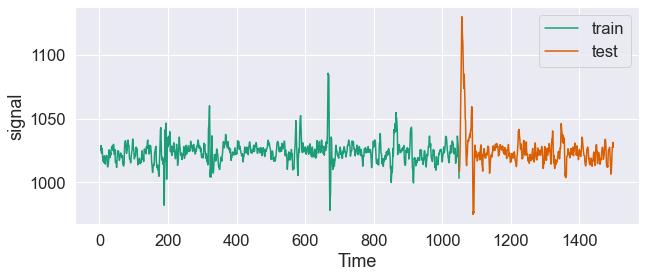

In [180]:
ndata = 1500
data = sit
data = data[:ndata]
train_frac = 0.7
column = data.columns[1]

data_train = data[:int(len(data)*train_frac)]
data_test  = data[int(len(data)*train_frac):]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
sns.set_theme(style='darkgrid', palette='Dark2', font_scale=1.5)
data_train[column].plot(ax=ax, label='train')
data_test[column].plot(ax=ax, label='test')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('signal')

In [181]:
# Create and train forecaster
# ==============================================================================
regressor = RandomForestRegressor(max_depth=100, n_estimators=1000, random_state=123)
forecaster = ForecasterAutoreg(regressor = regressor, lags = 30)

forecaster.fit(y=data_train[column].dropna())
# forecaster

In [182]:
# Predictions
# ==============================================================================
steps = len(data_test)
predictions = forecaster.predict(steps=steps)

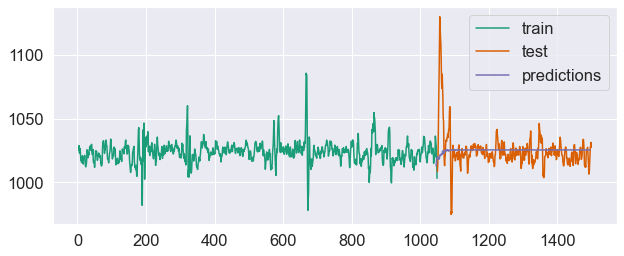

In [183]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train[column].plot(ax=ax, label='train')
data_test[column].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [148]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test[column], y_pred = predictions)
print(f"Test error (mse): {error_mse}")

Test error (mse): 2303.3174474148636


In [ ]:
# Lags used as predictors
steps = len(data_test)
lags_grid = [10, 20]
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train[column],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )
results_grid